In [77]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
import sys
import pathlib

sys.path.append(str(pathlib.Path().cwd().parent))

In [79]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D

In [80]:
from plotting import plot_ts

In [81]:
from dataset import Dataset
dataset = Dataset('../data/dataset/')

### Предсказание одномерного ряда на одну точку вперед

#### Выгрузим одномерный ряд alcohol_sales 

In [135]:
ts = dataset['alcohol_sales.csv']

<Axes: xlabel='0'>

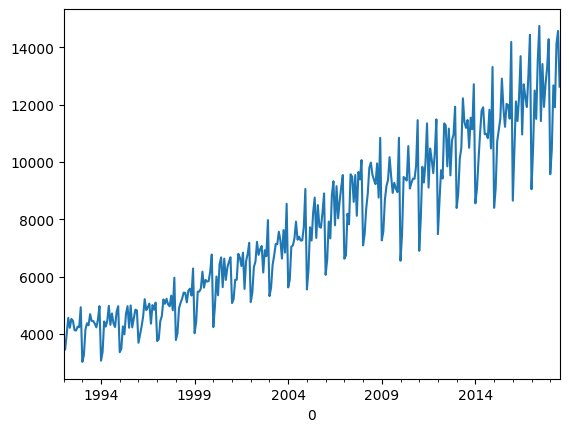

In [136]:
ts.plot()

#### Напишем функцию, которая переводит time series в матрицу обьекты-признаки

In [172]:
def transform_into_matrix(ts: pd.Series, num_lags: int) -> pd.DataFrame:
    """
    Transforms time series into lags matrix to allow
    applying supervised learning algorithms

    Parameters
    ------------
    ts
        Time series to transform
    num_lags
        Number of lags to use

    Returns
    --------
        train, test: np.arrays of shapes (ts-num_lags, num_lags), (num_lags,)
    """

    ts_values = ts.values
    data = {}
    for i in range(num_lags + 1):
        data[f'lag_{num_lags - i}'] = np.roll(ts_values, -i)

    lags_matrix = pd.DataFrame(data)[:-num_lags]
    lags_matrix.index = ts.index[num_lags:]

    return lags_matrix.drop('lag_0', axis=1).values, lags_matrix['lag_0'].values

In [173]:
NUM_LAGS = 24
X, y = transform_into_matrix(ts, NUM_LAGS)

In [174]:
X.shape

(295, 24)

#### Сделаем необходимый reshape к двумерному виду для сверточного слоя и разобьем на train, test 

In [175]:
X = X.reshape((X.shape[0], X.shape[1], 1))

split_idx = int(len(ts) * 0.7)
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

In [176]:
X[0]

array([[3459],
       [3458],
       [4002],
       [4564],
       [4221],
       [4529],
       [4466],
       [4137],
       [4126],
       [4259],
       [4240],
       [4936],
       [3031],
       [3261],
       [4160],
       [4377],
       [4307],
       [4696],
       [4458],
       [4457],
       [4364],
       [4236],
       [4500],
       [4974]])

In [188]:
y[0]

3075

#### Зададим входной сверточный слой модели.

In [189]:
model = Sequential()

In [194]:
### Обратим внимание на то, что для временных рядов используется свертка только в одном направлении по временной
### шкале - поэтому Conv1D
model.add(Conv1D(64, 18, activation='relu', input_shape=(NUM_LAGS, 1)))

ValueError: Input 0 of layer "conv1d_16" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 1)

#### Добавим Pooling для борьбы с переобучением (наличие/отсутствие пулинга как и выбор его типа опционален и зависит от длины вашего ряда, сложности паттерна и т.д., что влияет на переобучение вашей модели) 

In [191]:
model.add(MaxPooling1D())

#### Добавим слой Flatten для перехода к одномерному формату входных данных для полносвязной сети

In [192]:
model.add(Flatten())

#### Добавим пару промежуточных полносвязных слоев и выходной слой с одним нейроном для предсказания одной точки

In [193]:
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='relu'))

In [183]:
model.compile(optimizer='adam', loss='mse')

In [184]:
model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_test, y_test))

In [185]:
y_pred = model.predict(X_test).flatten()

3/3 [==============================] - 0s 1ms/step


<Axes: >

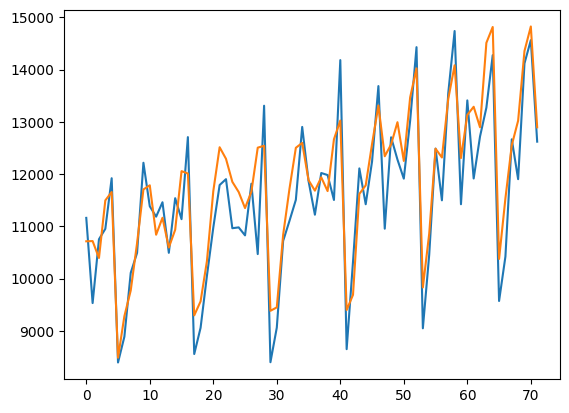

In [186]:
pd.Series(y_test).plot()
pd.Series(y_pred).plot()

### Векторное предсказание для одномерного ряда

Попробуем решить аналогичную предыдущему занятию задачу предсказания вектора следующих точек, но теперь добавим
в модель признаки, сгенерённые сверточным слоем 

#### 1) Возьмем функцию трансформации ряда из прошлого занятия

In [122]:
from typing import Tuple

def transform_ts_into_matrix(ts: pd.Series, num_lags_in: int, num_lags_out: int) -> Tuple[np.array, np.array]:
    """
    Данная функция должна пройтись скользящим окном по временному ряду и для каждых
    num_lags_in точек в качестве признаков собрать num_lags_out следующих точек в качестве таргета.
    
    Вернуть два np.array массива из X_train и y_train соответственно
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    outer_idx = num_lags_out
    while outer_idx < len(sequence):
        inner_idx = i + num_lags_in
        outer_idx = inner_idx + num_lags_out
        X_, y_ = sequence[i:inner_idx], sequence[inner_idx:outer_idx]
        X.append(X_)
        y.append(y_)
        i += 1
    return np.array(X), np.array(y)

#### 2) Приведем входные данные к двумерному виду

In [123]:
NUM_LAGS = 24
NUM_OUTPUT = 12
X, y = transform_ts_into_matrix(ts, NUM_LAGS, NUM_OUTPUT)
X = X.reshape((X.shape[0], X.shape[1], 1))

#### 3) Разобьем на трейн и тест, отложив в качестве теста последние 12 точек

In [126]:
X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[[-1]], y[-1]

In [127]:
X_train.shape

(283, 24, 1)

In [128]:
y_train.shape

(283, 12)

In [129]:
y_test = y_test.reshape((1, 12))

#### 4) Постройте сеть из CNN слоев, соединенных с полносвязными слоями 

In [130]:
model = Sequential()
model.add(Conv1D(64, 2, activation='relu', input_shape=(NUM_LAGS, 1)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(NUM_OUTPUT))
model.compile(optimizer='adam', loss='mse')

#### 5) Обучите модель

In [131]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
9/9 [==============================] - 0s 21ms/step - loss: 48117340.0000 - val_loss: 53812256.0000
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 11873331.0000 - val_loss: 7881553.5000
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 2385546.5000 - val_loss: 7594009.5000
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 2448278.2500 - val_loss: 3307833.0000
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 1366632.8750 - val_loss: 1813671.1250
Epoch 6/100
9/9 [==============================] - 0s 2ms/step - loss: 1156773.7500 - val_loss: 2275165.7500
Epoch 7/100
9/9 [==============================] - 0s 2ms/step - loss: 1012764.2500 - val_loss: 2525928.7500
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 968561.4375 - val_loss: 2200063.0000
Epoch 9/100
9/9 [==============================] - 0s 2ms/step - loss: 939184.7500 - val_loss: 1784798.6250
Epoch 10/100
9/9 

#### 5) Постройте предсказания (не забудьте вызвать метод flatten в конце предсказания)

In [132]:
y_pred = model.predict(X_test).flatten()

1/1 [==============================] - 0s 27ms/step


<Axes: >

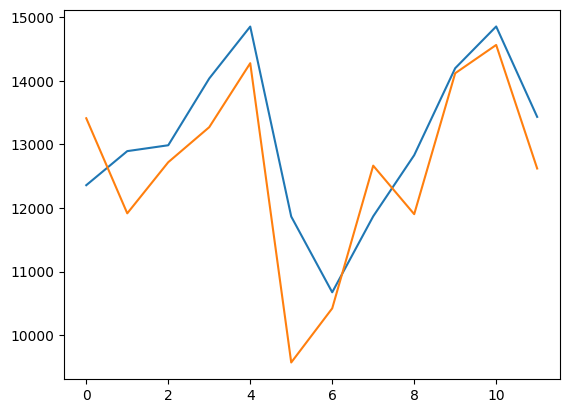

In [133]:
pd.Series(y_pred).plot()
pd.Series(y_test.flatten()).plot()

In [134]:
from sklearn.metrics import mean_absolute_error

#### 6) Постройте предсказание без добавления сверточных слоев и сравните качество

In [114]:
model = Sequential()
model.add(Conv1D(64, 2, activation='relu', input_shape=(NUM_LAGS, 1)))
model.add(MaxPooling1D())
model.add(Dense(64))
model.add(Dense(32))
model.add(Flatten())
model.add(Dense(NUM_OUTPUT))
model.compile(optimizer='adam', loss='mse')

In [115]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
9/9 [==============================] - 1s 11ms/step - loss: 47850608.0000 - val_loss: 28346434.0000
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 6142364.0000 - val_loss: 19660656.0000
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 3360478.2500 - val_loss: 4699874.0000
Epoch 4/100
9/9 [==============================] - 0s 2ms/step - loss: 2502600.5000 - val_loss: 1925206.6250
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 1381477.8750 - val_loss: 3762864.0000
Epoch 6/100
9/9 [==============================] - 0s 2ms/step - loss: 1166308.6250 - val_loss: 2281901.0000
Epoch 7/100
9/9 [==============================] - 0s 2ms/step - loss: 1103624.2500 - val_loss: 2534002.7500
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 1060367.3750 - val_loss: 2112666.7500
Epoch 9/100
9/9 [==============================] - 0s 3ms/step - loss: 1034631.3750 - val_loss: 2137924.7500
Epoch 10/100
9/

9/9 [==============================] - 0s 2ms/step - loss: 412354.5938 - val_loss: 642941.7500
Epoch 77/100
9/9 [==============================] - 0s 2ms/step - loss: 393378.8750 - val_loss: 683138.4375
Epoch 78/100
9/9 [==============================] - 0s 2ms/step - loss: 401803.4688 - val_loss: 740697.6875
Epoch 79/100
9/9 [==============================] - 0s 2ms/step - loss: 390305.3438 - val_loss: 928827.8125
Epoch 80/100
9/9 [==============================] - 0s 2ms/step - loss: 380012.2188 - val_loss: 973184.0625
Epoch 81/100
9/9 [==============================] - 0s 3ms/step - loss: 371258.1250 - val_loss: 585259.6250
Epoch 82/100
9/9 [==============================] - 0s 3ms/step - loss: 357260.1875 - val_loss: 940954.8125
Epoch 83/100
9/9 [==============================] - 0s 3ms/step - loss: 349178.2188 - val_loss: 851415.1875
Epoch 84/100
9/9 [==============================] - 0s 3ms/step - loss: 341155.8750 - val_loss: 599486.1250
Epoch 85/100
9/9 [=======================

In [116]:
y_pred = model.predict(X_test).flatten()

1/1 [==============================] - 0s 53ms/step


In [117]:
y_test

array([[13412, 11917, 12721, 13272, 14278,  9572, 10423, 12667, 11904,
        14120, 14565, 12622]])

<Axes: >

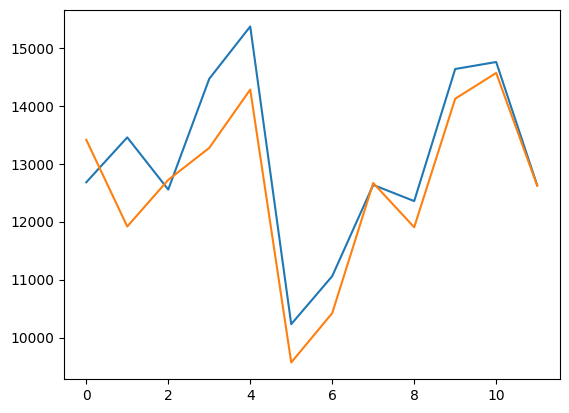

In [119]:
pd.Series(y_pred).plot()
pd.Series(y_test.flatten()).plot()

In [45]:
mean_absolute_error(y_test ,y_pred)

500.0393880208333

### Предсказание многомерного ряда

Где применение CNN вызывает наибольший интерес, так это в многомерных рядах или рядах с наличием экзогенных признаков, так как позволяет автоматически генерировать большое количество признаков из коррелирующих рядов.

В данном примере мы будем предсказывать каждую компоненту многомерного временного ряда, используя данные из всех компонент, т.е. каждая компонента будет в качестве признаков лаги всех соседних рядов, а CNN будет вычленять из них произвольные признаки.

In [196]:
ts = pd.read_csv('../data/stability_index.csv', index_col='timestamp', parse_dates=True)

In [197]:
ts.head()

,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,
2020-01-15 13:00:00,205.0,92.0,63.0,55.0,26.0,27.0,20.0,34.0,155.0
2020-01-15 14:00:00,173.0,97.0,69.0,44.0,31.0,22.0,41.0,26.0,182.0
2020-01-15 15:00:00,145.0,83.0,73.0,58.0,40.0,25.0,31.0,19.0,167.0
2020-01-15 16:00:00,84.0,60.0,53.0,39.0,32.0,31.0,19.0,15.0,102.0
2020-01-15 17:00:00,117.0,77.0,40.0,53.0,33.0,29.0,21.0,30.0,160.0


<Axes: xlabel='timestamp'>

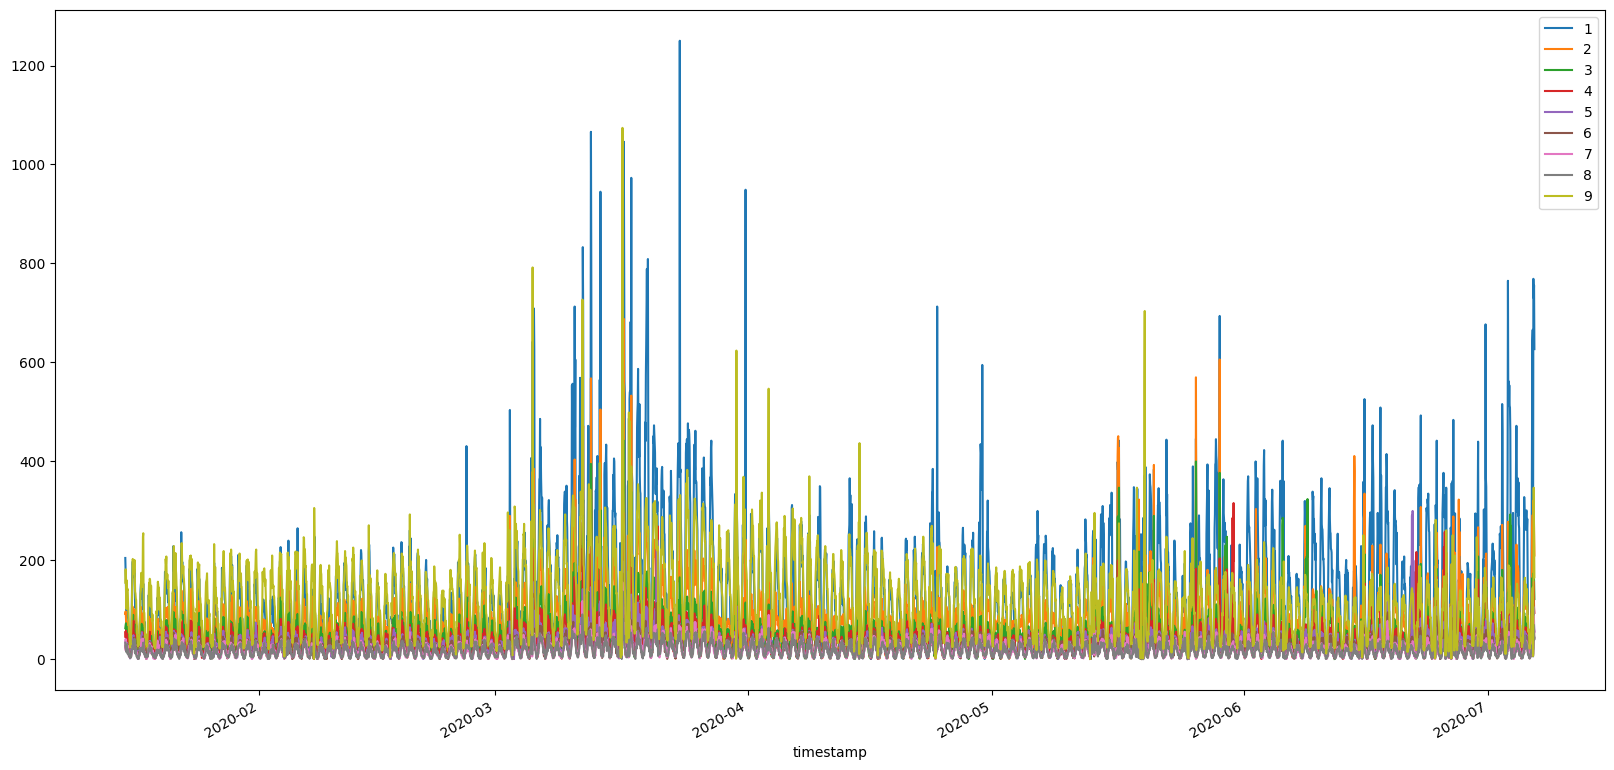

In [198]:
ts.plot(figsize=(20, 10))

In [199]:
import math

from pandas._libs.tslibs.timestamps import Timestamp


def get_month_sin(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.sin(theta)


def get_month_cos(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.cos(theta)


def get_day_sin(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*math.pi / timestamp.days_in_month)
    return math.sin(theta)


def get_day_cos(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*math.pi / timestamp.days_in_month)
    return math.cos(theta)


def get_dayofweek_sin(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*math.pi / 7)
    return math.sin(theta)


def get_dayofweek_cos(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*math.pi / 7)
    return math.cos(theta)


def get_hour_sin(timestamp: Timestamp) -> float:
    theta = timestamp.hour * (2*math.pi / 24)
    return math.sin(theta)


def get_hour_cos(timestamp: Timestamp) -> float:
    theta = timestamp.hour * (2*math.pi / 24)
    return math.cos(theta)


def get_minute_sin(timestamp: Timestamp) -> float:
    theta = timestamp.minute * (2*math.pi / 60)
    return math.sin(theta)


def get_minute_cos(timestamp: Timestamp) -> float:
    theta = timestamp.minute * (2*math.pi / 60)
    return math.cos(theta)


datetime_mappers = {
    'month_sin': get_month_sin,
    'month_cos': get_month_cos,
    'day_sin': get_day_sin,
    'day_cos': get_day_cos,
    'dayofweek_sin': get_dayofweek_sin,
    'dayofweek_cos': get_dayofweek_cos,
    'hour_sin': get_hour_sin,
    'hour_cos': get_hour_cos,
    'minute_sin': get_minute_sin,
    'minute_cos': get_minute_cos,
}

In [200]:
ts.fillna(ts.median(), inplace=True)

#### 1) Возьмем функцию из предыдущего занятия (исключая метод flaten в конце, так как CNN принимает как раз 2D данные)

In [206]:
def transform_multi_ts_into_matrix(ts: pd.DataFrame, num_lags: int):
    """
    Данная функция должна пройтись скользящим окном по временному ряду
    и собрать в качестве признаков X np.array размерности (len(ts)-num_lags, n_dims, num_lags),
    а в качестве y np.array размерности (len(ts)-num_lags, n_dims),
    где n_dims - размерность многомерного ряда.
    
    То есть для всех компонент временного ряда мы должны взять num_lags предыдущих точек каждой компонент
    в качестве признаков и все компоненты текущей точки в качестве target
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    end_i = num_lags
    while end_i < len(sequence): 
        seq_x, seq_y = sequence[i:end_i], sequence[end_i]
        X.append(seq_x.T)
        y.append(seq_y)
        i += 1
        end_i = i + num_lags
    return np.array(X), np.array(y)

In [207]:
NUM_LAGS = 14
NUM_DIMS = ts.shape[1]

In [208]:
X, y = transform_multi_ts_into_matrix(ts, NUM_LAGS)

In [209]:
# Видим, что в качестве обьекта мы получаем матрицу, где количество строк равно количеству компонент нашего ряда
# а количество столбцов количеству лагов, которое мы берем для каждой из компонент
X[0].shape

(9, 14)

In [210]:
y[0].shape

(9,)

In [211]:
X = X.reshape((4131, 14, 9))

In [212]:
X.shape

(4131, 14, 9)

#### 2) Разбейте на train/test

In [213]:
X_train, y_train = X[:-24], y[:-24]
X_test, y_test = X[-24:], y[-24:]

#### 3) Постройте сеть, со сверточным слоем и несколькими полносвязными в конце (подумайте какой shape входных и выходных данных должен быть у первого и последнего слоя)

In [216]:
model = Sequential()
model.add(Conv1D(32, 6, activation='relu', input_shape=(14, 9)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(9))
model.compile(optimizer='adam', loss='mse')


#### 4) Обучите модель

In [217]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
129/129 [==============================] - 0s 1ms/step - loss: 2538.7417 - val_loss: 5147.1353
Epoch 2/100
129/129 [==============================] - 0s 825us/step - loss: 1408.8271 - val_loss: 4982.0454
Epoch 3/100
129/129 [==============================] - 0s 880us/step - loss: 1221.4604 - val_loss: 4567.6216
Epoch 4/100
129/129 [==============================] - 0s 900us/step - loss: 1154.5103 - val_loss: 4828.8433
Epoch 5/100
129/129 [==============================] - 0s 877us/step - loss: 1097.2079 - val_loss: 4354.4336
Epoch 6/100
129/129 [==============================] - 0s 921us/step - loss: 1078.3665 - val_loss: 4337.4224
Epoch 7/100
129/129 [==============================] - 0s 828us/step - loss: 1041.9141 - val_loss: 4354.7319
Epoch 8/100
129/129 [==============================] - 0s 912us/step - loss: 1008.3442 - val_loss: 4668.9883
Epoch 9/100
129/129 [==============================] - 0s 849us/step - loss: 991.7206 - val_loss: 4180.2202
Epoch 10/100
129/129 [

#### 5) Сделайте предсказание на тесте

In [218]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 26ms/step


<Axes: >

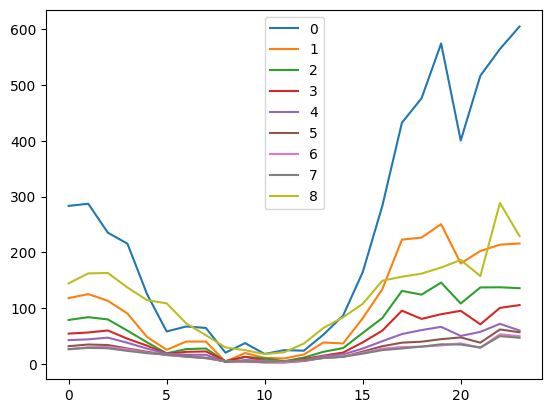

In [219]:
pd.DataFrame(y_pred).plot()

<Axes: >

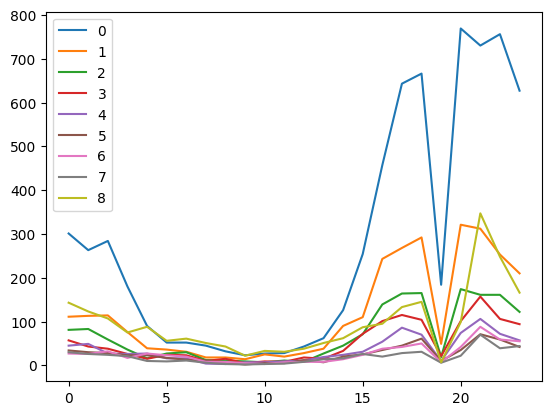

In [220]:
pd.DataFrame(y_test).plot()

In [243]:
plot_ts(pd.Series(y_test[:, 0]), pd.Series(y_pred[:, 0]))

Loading BokehJS ...

In [174]:
X_train, y_train = X[:-24], y[:-24]
X_test, y_test = X[-24:], y[-24:]

#### 6) Сравните полученые предсказания с предсказанием каждой компоненты как отдельного ряда при помощи TimeSeriesPredictor

* Разбейте ряд на 9 одномерных рядов
* Обучите модель TimeSeriesPredictor
* Сделайте батч предсказание на длину X_test
* сравните результаты с CNN

In [229]:
def train_test_split(ts: pd.Series, ratio: float = 0.7) -> Tuple[pd.Series]:
    split_idx = 24
    ts_train, ts_test = ts[:-split_idx], ts[-split_idx:]
    # ваш код здесь
    return ts_train, ts_test

In [230]:
def make_pipeline(
    ts: pd.Series,
    granularity: str,
    model: callable,
    num_lags=24,
    use_mappers=True,
    **kwargs
) -> Tuple[pd.Series]:
    
    train, test = train_test_split(ts)
    
    predictor = TimeSeriesPredictor(
        granularity=granularity,
        num_lags=num_lags,
        model=model,
    )
    
    if use_mappers:
        predictor.set_params(mappers=datetime_mappers)
        
    predictor.set_params(**kwargs)
    predictor.fit(train)
    
    in_sample = predictor.predict_batch(train, test)
    out_of_sample = predictor.predict_next(train, len(test))
    
   
    out_of_sample.index = test.index
    
    return train, test, in_sample, out_of_sample

In [231]:
X_train[0].shape# ваш код здесь

(14, 9)

In [232]:
y_train[0].shape

(9,)

In [233]:
y_train.shape

(4107, 9)

In [234]:
y_train.reshape(-1,1).shape

(36963, 1)

In [235]:
y_train

array([[ 23.,  13.,  13., ...,   5.,   3.,  24.],
       [ 19.,   9.,   7., ...,   3.,   3.,  32.],
       [ 22.,  18.,   5., ...,   4.,   5.,  31.],
       ...,
       [262., 116.,  68., ...,  23.,  22., 152.],
       [284., 102.,  62., ...,  32.,  22., 145.],
       [301., 108.,  75., ...,  38.,  34., 110.]])

In [236]:
ts_0= []
for i in range(len(y_train)):
    ts_0.append(y_train[i][0])
    

In [237]:
len(ts_0)

4107

In [238]:
ts_0 = pd.Series(ts_0, index = ts[:-38].index)

In [239]:
from model import TimeSeriesPredictor

In [240]:
ts_0.fillna(0,inplace=True)

In [241]:
from sklearn.linear_model import LinearRegression
ts = ts_0
granularity = 'PT1H'
model = LinearRegression
num_lags = 24
params = {}
train, test, in_sample, out_of_sample = make_pipeline(ts_0, granularity, model, num_lags, use_mappers=True, **params)

In [242]:
plot_ts(train, test, out_of_sample)

Loading BokehJS ...

#### 7) Сделайте то же самое, что и в 6 пункте, но теперь добавьте в качестве признаков для каждого одномерного ряда лаги от всех остальных 8 рядов. Получился ли результат лучше чем CNN?

In [43]:
# ваш код здесь